<a href="https://colab.research.google.com/github/ishmam24/AirBnb_SanDiego/blob/main/05_Airbnb_preprocessing_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## We dont need to get the data from gdrive. We can directly download from the source. (Saves us the hassle of mounting gdrive)

In [ ]:
import math
import functools
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import KNNImputer


## Get the Data

In [ ]:
# filepath = '/content/drive/MyDrive/Colab_Notebooks/ML_Project/rawdata.csv'
file_url = 'https://query.data.world/s/g5ykrkenwn4xjrmo3urgh6lnna6sb7?dws=00000'

dataset = pd.read_csv(file_url)
dataset.head()

,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,33159143,https://www.airbnb.com/rooms/33159143,"PRIVATE ROOM, SAFE NEIGHBORHOOD IN SCRIPPS RANCH",80% of the house + yourCozy room ... in Scripp...,"Full bed, private bath...",80% of the house + yourCozy room ... in Scripp...,The neighborhood is a typical Southern Califor...,Have alarm system if you choose to use... I wi...,You can park in the drive way or plenty of spa...,"Kitchen, Dining room, Living room, Very Comfor...",...,NaN,NaN,NaN,NaN,f,t,f,strict_14_with_grace_period,f,f
1,17138468,https://www.airbnb.com/rooms/17138468,NOT AVAILABLE,AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...,NaN,AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...,NaN,NaN,NaN,NaN,...,10.0,10.0,10.0,10.0,f,t,f,strict_14_with_grace_period,f,f
2,21898446,https://www.airbnb.com/rooms/21898446,Townhome in Pacific Beach,Hi! We are basically renting this master for a...,NaN,Hi! We are basically renting this master for a...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,f,t,f,flexible,f,f
3,25948680,https://www.airbnb.com/rooms/25948680,Spacious furnished 1 BR with tons of amenaties,"All my stuff will be gone. Dishwasher, washer/...",Lobby provides free coffee. Building doors loc...,"All my stuff will be gone. Dishwasher, washer/...",College area,NaN,Across the street from the green line trolly. ...,Everything except second bedroom in apartment....,...,NaN,NaN,NaN,NaN,f,f,f,flexible,f,f
4,1756516,https://www.airbnb.com/rooms/1756516,A Spacious luxury retreat,"NIcely furnished. Great location, 2 blocks to ...",NaN,"NIcely furnished. Great location, 2 blocks to ...",coastal town great travel destination.,NaN,Bus line near by.,NaN,...,8.0,8.0,9.0,10.0,f,f,f,strict_14_with_grace_period,f,f


## Data Cleaning Functions
- functions that drop some rows or columns in the data
- All the preprocessing steps will be added to preprocessing pipeline

In [ ]:
# Function to remove unneccessary columns
def get_unnecessary_columns(keep_col = []):

  """This is as defined by Erick.
  Additions by Aman wherever commented with name"""
  drop_cols_list= [ "id"
      , "listing_url"
      , "host_url"
      , "name"
      , "summary"
      , "space"
      , "description"
      , "neighborhood_overview"
      , "notes"
      , "transit"
      , "access"
      , "interaction"
      , "thumbnail_url"
      , "host_name"
      , "host_about"
      , "host_id"
      , "host_location"
      , "host_neighbourhood"
      , "host_since"
      , "street"
      , "neighbourhood"
      , "neighbourhood_cleansed"
      , "city"
      , "state"
      , "smart_location"
      , "country_code"
      , "country"
      , "first_review"
      , "last_review"
      , "host_listings_count"
      , "host_total_listings_count"
      , "minimum_nights"
      , "maximum_nights"
      , "house_rules"
      , "market"
      , "host_acceptance_rate" # All values are NaNs
      , "square_feet" # Entries with NaN in square_feet 0.9871274231859628
      , "is_business_travel_ready" # Only 1 unique value (Aman)
      , "requires_license"# Only 1 unique value (Aman)
      , "zipcode"
      , "amenities"
      #, "price_per_stay" #as discussed (keeing nightly_price col only). If commented, means used for data cleaning. Will be dropped after that
  ]
  return [col for col in drop_cols_list if col not in keep_col]


In [ ]:


def convert_price_str_to_decimal(price):
  """ To convert prices in string to float"""
  if isinstance(price, str):
    try:
      price = price.replace("$", "")
      price = price.replace(",", "")
      price = price.strip()
      #price = price.replace(".", "")
      return float(price)
    except:
      return -1 # To represent NaNs?
  else:
    return float(price)

def clean_host_response_rate(rate):
  """Function to convert host_response_rate col from string to numerical"""
  if isinstance(rate, str):
    rate = rate.replace("%", "").strip()
    return int(rate)
  return rate
def get_numerial_cols_list(data, ignore=True):
  """ Function to get numerical columns in the data as a list"""

  cols_to_ignore = ['latitude', 'longitude', 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

  numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
  if ignore:
    for col in cols_to_ignore:
        if col in numerical_cols:
            numerical_cols.remove(col)
  return numerical_cols

def get_numerical_data(data):
  """Function to get Numerical Data for plotting purposes"""

  numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
  cols_to_ignore = ['latitude', 'longitude', 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

  for col in cols_to_ignore:
    if col in numerical_cols:
      numerical_cols.remove(col)

  return data[numerical_cols]

def knn_impute_na_in_numerical_data(data, neighbors = 5):
  """ Function to use KNN Imputer to fill missing values in numerical cols"""

  numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
  cols_to_ignore = ['latitude', 'longitude'] # these cols not ideal for knn imputer

  # cols to use for knn imputer. (Remember knn imputer only takes in numerical data)
  for col in cols_to_ignore:
    if col in numerical_cols:
      numerical_cols.remove(col)

  # Initialize the scaler
  scaler = MinMaxScaler()

  # Fit the scaler to your data and transform it
  scaled_data = scaler.fit_transform(data[numerical_cols])

  # Initialize KNN Imputer
  imputer = KNNImputer(n_neighbors=neighbors)

  # Impute on scaled_data
  imputed_scaled_data = imputer.fit_transform(scaled_data)

  # If you want to transform the imputed and scaled data back to the original scale
  imputed_scaled_data_inv = scaler.inverse_transform(imputed_scaled_data)

  # rounding the values because our original values dont have any decimal values
  imputed_scaled_data_inv = np.ceil(imputed_scaled_data_inv)
  imputed_scaled_data_inv = np.where(imputed_scaled_data_inv == -0.0, 0.0, imputed_scaled_data_inv)

  # creating a df from the array
  numerical_data = pd.DataFrame(imputed_scaled_data_inv, columns=numerical_cols, index=data.index)

  # replacing missing value cols with imputed cols
  for col in numerical_cols:
    data[col] = numerical_data[col]


  return data

def cols_with_nan(data):
  """function that returns only cols with missing values and count of missing values"""
  null_counts = data.isna().sum()
  null_counts = null_counts[null_counts > 0]
  return null_counts

def has_nans(data, column):
  """ Tells if a column has null values"""
  has_nans = False
  for row in data[column]:
    has_nans |= isinstance(row, float) and math.isnan(row)
    if has_nans:
      break
  return has_nans # True or False

def one_hot_encoding(data, column):
  """For categories, some have NaNs... so let's not drop the first one."""
  return pd.get_dummies(data, columns=[column], drop_first=not has_nans(data, column))

def get_categorical_cols(df):
  """
  Returns a list of categorical columns in a Pandas DataFrame.
  """
  return list(df.select_dtypes(include=['object']).columns)


def one_hot_encode_all(data):
  cat_cols = get_categorical_cols(data)

  for col in cat_cols:
    data = one_hot_encoding(data, col)

  return data

def group_rare_property_types(data):
  """
  This Function labels property_type categories that appean less than 5 times in whole data as "Other"
  """
  category_counts = data['property_type'].value_counts()

  # Identify categories that appear less than 5 times
  rare_categories = category_counts[category_counts < 5].index

  # Replace rare categories with 'Others'
  data['property_type'] = data['property_type'].replace(rare_categories, 'Others')
  return data

def group_alt_bed_types(data):
  """
  This Function groups all bed_types except "Real Bed" as "Not Real Bed"
  """
  # Get list of bed types except "Real Bed"
  alt_bed_types = data[data['bed_type']!='Real Bed']['bed_type'].unique()

  # Replace all those with "Not Real Bed"
  data['bed_type'] = data['bed_type'].replace(alt_bed_types, 'Not Real Bed')

  return data



In [ ]:
def clean_data(data):
  """ Function that consolidates all the cleaning steps into one function"""

  # Dropping Unnecessary columns
  data = data.drop(get_unnecessary_columns(), axis="columns")

  # removing rows with null values for bathrooms, bedroomms and beds (because very few instances)
  bitmask1 = data["bathrooms"].notnull()
  data = data[bitmask1]

  bitmask2 = data["bedrooms"].notnull()
  data = data[bitmask2]

  bitmask3 = data["beds"].notnull()
  data = data[bitmask3].reset_index(drop=True)

  # Cleaning and converting money data from str to float
  data['nightly_price'] = data['nightly_price'].apply(lambda x: convert_price_str_to_decimal(x))
  data['price_per_stay'] = data['price_per_stay'].apply(lambda x: convert_price_str_to_decimal(x))
  data['extra_people'] = data['extra_people'].apply(lambda x: convert_price_str_to_decimal(x))
  data['security_deposit'] = data['security_deposit'].apply(lambda x: convert_price_str_to_decimal(x))
  data['cleaning_fee'] = data['cleaning_fee'].apply(lambda x: convert_price_str_to_decimal(x))

  # dropping rows with number_of_stays==0
  data = data[data['number_of_stays']>0].reset_index(drop=True)

  # there were some rows with nightly_price ==0. So removing that also
  data = data[data['nightly_price']>0].reset_index(drop=True)
  # And removing instances with nightly price greater than 3000 and equal to price per stay (because we are not sure if it is nightly price or price per stay)
  data = data[~((data['nightly_price']==data['price_per_stay']) & (data['nightly_price']>3000))]

  # Dropping price_per_stay
  data = data.drop(['price_per_stay'], axis="columns")

  # Removing outlier in bathrooms col. Only one instance with 20 bathrooms. after that, max bathrooms are 10
  data = data[data['bathrooms']<20].reset_index(drop=True)

  # Cleaning and converting host_response_rate data from str to numerical
  data['host_response_rate'] = data['host_response_rate'].apply(lambda x: clean_host_response_rate(x))

  # Label Property types that appear less than 5 times in the dataset as "Other"
  data = group_rare_property_types(data)

  # Label all bed_types except Real Bed as Not Real Bed. Bed_types such as Futon, Couch, Sofa and Airbed will be labeled as Not Real Bed
  data = group_alt_bed_types(data)

  return data

In [ ]:
def custom_winsorize(data, lower_percentile, upper_percentile):
    """
    Winsorize data by replacing values outside the lower and upper percentiles
    with the boundary values at these percentiles.

    Parameters:
    - data: The data to be winsorized (a numpy array or a list).
    - lower_percentile: The lower percentile limit (e.g., 0.05 for the 5th percentile).
    - upper_percentile: The upper percentile limit (e.g., 0.95 for the 95th percentile).

    Returns:
    - Winsorized data as a numpy array.
    """
    lower_bound = np.percentile(data, lower_percentile * 100)
    upper_bound = np.percentile(data, upper_percentile * 100)

    # Replace values below the lower bound with the lower bound value
    # and above the upper bound with the upper bound value
    winsorized_data = np.clip(data, lower_bound, upper_bound)

    return winsorized_data
def apply_winsorizing(dataframe, lower_percentile=0.05, upper_percentile=0.95):
    """
    Apply Winsorizing to specified columns in a pandas DataFrame.

    :param dataframe: The pandas DataFrame containing the data.

    :param lower_percentile: The lower percentile for Winsorizing (default is 0.05).
    :param upper_percentile: The upper percentile for Winsorizing (default is 0.95).

    :return: A pandas DataFrame with Winsorized columns.
    """
    columns = get_numerial_cols_list(dataframe)
    winsorized_data = dataframe.copy()
    for column in columns:
        winsorized_data[column] = custom_winsorize(winsorized_data[column], lower_percentile, upper_percentile)
    return winsorized_data

In [ ]:
data = clean_data(dataset)
data.shape

(11007, 33)

## Splitting the data into Train and Test Data Sets

In [ ]:
#Split Data train test split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['property_type'])

In [ ]:
# Further split the training data into X and y
X_train = train_set.drop(['nightly_price'], axis=1)
y_train = train_set['nightly_price'].copy()

# apply winsorizing on target variable
y_train = custom_winsorize(y_train, 0, 0.95)

In [ ]:
# Similarly for test set
X_test = test_set.drop(['nightly_price'], axis=1)
y_test = test_set['nightly_price'].copy()

# winsorize the target variable in the test set
y_test = custom_winsorize(y_test, 0, 0.95)

In [ ]:
X_train.shape, y_train.shape

((8805, 32), (8805,))

## Data Preprocessing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# Numerical Attributes Preprocessing functions/steps
def fill_nan_in_money_cols(data):
  # # imputing money cols with 0 for no data. (Assuming no data means nothing mentioned about deposit or fees meaning none exist for those listings)
  data['security_deposit'].fillna(0, inplace=True)
  data['cleaning_fee'].fillna(0, inplace=True)
  return data


In [ ]:
# let's get the numerical data
X_train_num = X_train.select_dtypes(include=[np.number])
X_train_num.shape

(8805, 20)

In [ ]:
num_pipeline = Pipeline([
      ('fill_nan', FunctionTransformer(fill_nan_in_money_cols))
    , ('knn_impute', FunctionTransformer(knn_impute_na_in_numerical_data))
    , ('winsorizing', FunctionTransformer(apply_winsorizing))
    , ('Normalization', MinMaxScaler()) # comment out normalization if you dont need
])


In [ ]:
 #use the pipeline object to fit and transform the numerical features of the listings data

X_train_num = num_pipeline.fit_transform(X_train_num)
X_train_num

array([[1.        , 0.56937885, 0.03921795, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.47719817, 0.59338848, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.39936551, 0.29618811, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 0.4805148 , 0.09130611, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 0.39752695, 0.65131883, ..., 1.        , 0.875     ,
        0.875     ],
       [1.        , 0.40699016, 0.48363026, ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
# Categorical Data functions

def fill_missing_bools(data):
  # # imputing missing values in bool columns with f. (Assuming no data as false )
  data['host_is_superhost'].fillna('f', inplace=True)
  data['host_has_profile_pic'].fillna('f', inplace=True)
  data['host_identity_verified'].fillna('f', inplace=True)
  return data

In [ ]:
# cat_pipeline = Pipeline([
#     ('fill_bools', FunctionTransformer(fill_missing_bools)),
#     ('one_hot_encode', FunctionTransformer(one_hot_encode_all))
# ])


In [ ]:
# Let's get the categorical data
cat_data = X_train[get_categorical_cols(X_train)].copy()

In [ ]:
cat_pipeline1 = Pipeline([
     ('fill_bools', FunctionTransformer(fill_missing_bools))
    , ('one_hot_encode', OneHotEncoder(sparse_output=False, drop='first'))
])


In [ ]:
cat_data = cat_pipeline1.fit_transform(cat_data)
cat_data

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
cat_data.shape

(8805, 41)

In [ ]:
# Let's get the categorical cols list and numerical cols list for the full data preprocessing pipeline

cat_attribs = get_categorical_cols(X_train) # this will return a list
num_attribs = X_train.select_dtypes(include=[np.number]).columns.tolist()

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
# Define your pipeline steps
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline1, cat_attribs),
    ])

In [ ]:
train_prepared = full_pipeline.fit_transform(X_train)

In [ ]:
train_prepared

array([[1.        , 0.56937885, 0.03921795, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.47719817, 0.59338848, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.39936551, 0.29618811, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.4805148 , 0.09130611, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.39752695, 0.65131883, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.40699016, 0.48363026, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
train_prepared.shape

(8805, 61)

In [ ]:
# To check the column names

# Access the OneHotEncoder inside the ColumnTransformer
onehotencoder = full_pipeline.named_transformers_['cat'].named_steps['one_hot_encode']

# This will give you the names of all the one-hot encoded columns
one_hot_feature_names = onehotencoder.get_feature_names_out(cat_attribs)
one_hot_feature_names

array(['host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_response_time_nan',
       'host_is_superhost_t', 'host_has_profile_pic_t',
       'host_identity_verified_t', 'is_location_exact_t',
       'property_type_Apartment', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Camper/RV',
       'property_type_Condominium', 'property_type_Cottage',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_Hotel',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Others', 'property_type_Resort',
       'property_type_Serviced apartment', 'property_type_Tent',
       'property_type_Tiny house', 'property_type_Townhouse',
       'property_type_Villa', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Re

In [ ]:
# Let's try it on test set too
test_prepared = full_pipeline.transform(X_test)

In [ ]:
test_prepared.shape

(2202, 61)

## Select and Train a Model

In [ ]:
def model_rmse(trained_model, independent_data, target_data):
  y_preds = trained_model.predict(independent_data)
  mse = mean_squared_error(target_data, y_preds)
  rmse = np.sqrt(mse)
  return rmse

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
#use LinearRegression to fit the data
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error
#evaluate the predictions uing MSE and RMS

#on train set
y_preds = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(y_train, y_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

NameError: name 'lin_reg' is not defined

In [ ]:
# on test set

model_rmse(lin_reg, test_prepared, y_test)

398339215296.04034

In [ ]:
y_test[:10]

1294     135.0
6513     142.0
1659     100.0
8600     150.0
4220     130.0
1613     100.0
6214     100.0
7500     154.0
1253      95.0
10594    599.0
Name: nightly_price, dtype: float64

In [ ]:
y_preds = lin_reg.predict(test_prepared)
y_preds[:10]

array([139.70958994, 145.36779307, 130.54748057, 315.57091807,
       140.33849619, 105.79748057, 120.32482432, 175.52794932,
        94.70470713, 491.4425001 ])

In [ ]:
np.sqrt(mean_squared_error(y_preds, y_test))

398339215296.04034

Typical case of Overfitting on the training data. Potential Remedies:
- L1 and L2 Regularization
- More Data
- Reduce Features
- Cross-Validation

In [ ]:
# Let's try regularization
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [ ]:
# Alpha is the regularization strength
ridge_model = Ridge(alpha=1.0)

# Fit the model with your data (X_train and y_train)
ridge_model.fit(train_prepared, y_train)

Ridge()

In [ ]:
# train set rmse
model_rmse(ridge_model, train_prepared, y_train)

78.06864020113328

In [ ]:
# on test set
model_rmse(ridge_model, test_prepared, y_test)

82.86854758873744

Wow. A lot improvement.

In [ ]:
# Let's try lasso
# Initialize the Lasso regression model with an alpha value
lasso_model = Lasso(alpha=1)

# Fit the model with your data (X_train and y_train)
lasso_model.fit(train_prepared, y_train)


Lasso(alpha=1)

In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(lasso_model, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(lasso_model, test_prepared, y_test)}")

RMSE on Train Set: 80.60883574362036
RMSE on Test Set: 85.52220323276879


In [ ]:
# Let's try Elastic Net

# Initialize ElasticNet model
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5)  # l1_ratio corresponds to the mix of L1 and L2

# Fit the model
elastic_net.fit(train_prepared, y_train)


ElasticNet(alpha=1)

In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(elastic_net, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(elastic_net, test_prepared, y_test)}")

RMSE on Train Set: 101.90347109029065
RMSE on Test Set: 109.55665747745131


In [ ]:
# Let's try GridSearchCV

from sklearn.model_selection import GridSearchCV

In [ ]:

# Define a single pipeline stage with a placeholder estimator
pipeline = Pipeline([('estimator', Ridge())])

# Define the parameter grid to search
param_grid = [
    {'estimator': [Ridge()],
     'estimator__alpha':  [0.5, 0.75, 1, 1.25, 1.5]}, #since alpha=1 gives good good results
    {'estimator': [Lasso()],
     'estimator__alpha': [0.5, 0.75, 1, 1.25, 1.5]},
    {'estimator': [ElasticNet()],
     'estimator__alpha':  [0.5, 0.75, 1, 1.25, 1.5],
     'estimator__l1_ratio': [0.2, 0.5, 0.8]}
]

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search.fit(train_prepared, y_train)

# Output the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", np.sqrt(-grid_search.best_score_))

# You can access the best estimator directly
best_model = grid_search.best_estimator_.named_steps['estimator']


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'estimator': Ridge(alpha=1.5), 'estimator__alpha': 1.5}
Best cross-validation score: 78.83275467169146


In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(best_model, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(best_model, test_prepared, y_test)}")

RMSE on Train Set: 78.07540845752695
RMSE on Test Set: 82.87010966639706


Looks promising

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeRegressor
#use DecisionTreeRegressor to fit the data
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_prepared, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:

# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(tree_reg, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(tree_reg, test_prepared, y_test)}")

RMSE on Train Set: 0.0
RMSE on Test Set: 104.57754424887902


Again, another typical case of Overfitting. Potential Remedies:
- More Data
- Pruning the tree by controlling parameters such as max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes
- Feature Selection
- Ensemble Methods such as Random Forest Regressor or Gradient Boosted Trees
- Regularization techniques

In [ ]:
# Let's try Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
#use RandomForestRegressor to fit the data
forest_reg = RandomForestRegressor(n_estimators=50, random_state=42) # nominal improvement at n_estimators=100
forest_reg.fit(train_prepared, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(forest_reg, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(forest_reg, test_prepared, y_test)}")

RMSE on Train Set: 26.92553463283607
RMSE on Test Set: 74.89653735710056


n_estimators=10
RMSE on Train Set: 31.718261443984613
RMSE on Test Set: 77.62235333074545


---

n_estimators=20
RMSE on Train Set: 28.876931324011082
RMSE on Test Set: 75.87533833551926

---




 Is this also a case of Overfitting? Yes, it still is overfitting. The ideal rmse of train and test set should have small gap.

In [ ]:
#display the mean score and its standard deviation
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
from sklearn.model_selection import cross_val_score
#display the scores of RandomForestRegressor using cross validation
forest_scores = cross_val_score(forest_reg, train_prepared, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [78.73705598 66.6758205  72.87790662 73.66339587 73.63493032 73.13109314
 74.99931454 80.75299347 68.38759457 80.72553844]
Mean: 74.35856434538275
Standard deviation: 4.476514314535095


In [ ]:
# Adjust these parameters to combat overfitting
forest_reg = RandomForestRegressor(n_estimators=50,    # Consider testing with 200, 300, etc.
                           max_depth=10,        # Try None, 5, 10, 20, etc.
                           min_samples_split=2, # Can be increased to require more samples to split a node
                           min_samples_leaf=1,  # Can be increased to require more samples at a leaf node
                           #max_features='auto', # Can be set to 'sqrt' or a fraction of features
                           bootstrap=True,      # Default is True; setting to False uses the whole dataset
                           random_state=42)

forest_reg.fit(train_prepared, y_train)

# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(forest_reg, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(forest_reg, test_prepared, y_test)}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSE on Train Set: 49.23930056043469
RMSE on Test Set: 76.02725087086276


In [ ]:
#Let's use GridSearchCV for parameter tuning
param_grid = {
    'n_estimators': [40, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    #'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(train_prepared, y_train)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [40, 50, 100]},
             scoring='neg_mean_squared_error')

In [ ]:
# Output the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", np.sqrt(-grid_search.best_score_))

# You can access the best estimator directly
best_model = grid_search.best_estimator_



Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 71.50189753591259


In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(best_model, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(best_model, test_prepared, y_test)}")

RMSE on Train Set: 33.283517567344916
RMSE on Test Set: 74.43852040697696


In [ ]:
# Let's try again with diff values

param_grid = {
    # 'n_estimators': [40, 50, 100],
    'max_depth': [None, 50, 60],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [2, 3],
    'max_features': [0.1, 0.5, 1],
    'min_impurity_decrease':[0.0, 0.01, 0.1, 0.5]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(train_prepared, y_train)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 50, 60],
                         'max_features': [0.1, 0.5, 1],
                         'min_impurity_decrease': [0.0, 0.01, 0.1, 0.5],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [4, 6]},
             scoring='neg_mean_squared_error')

In [ ]:
# Output the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", np.sqrt(-grid_search.best_score_))

# You can access the best estimator directly
best_model = grid_search.best_estimator_

# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(best_model, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(best_model, test_prepared, y_test)}")

Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 4}
Best cross-validation score: 71.02766779158347
RMSE on Train Set: 34.93482693906558
RMSE on Test Set: 74.73303184348882


Let's compute confidence Interval for the test rmse

In [ ]:
from scipy import stats

In [ ]:
confidence = 0.95
final_predictions = best_model.predict(test_prepared)
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)
#this interval assumes the score is a Student’s t continuous random variable
np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([70.27277055, 78.94168617])

### SVR

In [ ]:
from sklearn.svm import SVR

Tune using RBF

In [ ]:
param_grid = {
    'kernel':['rbf'],
    'C': [ i for i in range(8100,8500, 50)],
    'epsilon': [i for i in range (35, 47, 2)]
}

VectorRegressor = SVR(kernel='rbf',gamma='auto')

grid_search = GridSearchCV(estimator=VectorRegressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(train_prepared, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END .....................C=8100, epsilon=35, kernel=rbf; total time=   6.5s
[CV] END .....................C=8100, epsilon=35, kernel=rbf; total time=   5.9s
[CV] END .....................C=8100, epsilon=35, kernel=rbf; total time=   7.7s
[CV] END .....................C=8100, epsilon=37, kernel=rbf; total time=   5.7s
[CV] END .....................C=8100, epsilon=37, kernel=rbf; total time=   6.7s
[CV] END .....................C=8100, epsilon=37, kernel=rbf; total time=   5.3s
[CV] END .....................C=8100, epsilon=39, kernel=rbf; total time=   6.2s
[CV] END .....................C=8100, epsilon=39, kernel=rbf; total time=   5.7s
[CV] END .....................C=8100, epsilon=39, kernel=rbf; total time=   5.7s
[CV] END .....................C=8100, epsilon=41, kernel=rbf; total time=   5.6s
[CV] END .....................C=8100, epsilon=41, kernel=rbf; total time=   5.2s
[CV] END .....................C=8100, epsilon=4

GridSearchCV(cv=3, estimator=SVR(gamma='auto'),
             param_grid={'C': [8100, 8150, 8200, 8250, 8300, 8350, 8400, 8450],
                         'epsilon': [35, 37, 39, 41, 43, 45],
                         'kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best SVR model
best_svr = grid_search.best_estimator_

# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(best_svr, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(best_svr, test_prepared, y_test)}")

Best Parameters: {'C': 8450, 'epsilon': 37, 'kernel': 'rbf'}
RMSE on Train Set: 69.00976931461948
RMSE on Test Set: 76.70714234258043


In [ ]:
param_grid = {
    'kernel':['poly'],
    'C': [ i for i in range(70,140,10)],
    'epsilon': [i for i in range(45,57,2)],
    'degree': [2]
}

VectorRegressor = SVR(kernel='rbf',gamma='auto')

grid_search = GridSearchCV(estimator=VectorRegressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(train_prepared, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] END ............C=70, degree=2, epsilon=45, kernel=poly; total time=   1.7s
[CV] END ............C=70, degree=2, epsilon=45, kernel=poly; total time=   1.7s
[CV] END ............C=70, degree=2, epsilon=45, kernel=poly; total time=   1.6s
[CV] END ............C=70, degree=2, epsilon=47, kernel=poly; total time=   1.6s
[CV] END ............C=70, degree=2, epsilon=47, kernel=poly; total time=   1.8s
[CV] END ............C=70, degree=2, epsilon=47, kernel=poly; total time=   2.2s
[CV] END ............C=70, degree=2, epsilon=49, kernel=poly; total time=   1.5s
[CV] END ............C=70, degree=2, epsilon=49, kernel=poly; total time=   1.5s
[CV] END ............C=70, degree=2, epsilon=49, kernel=poly; total time=   1.4s
[CV] END ............C=70, degree=2, epsilon=51, kernel=poly; total time=   1.4s
[CV] END ............C=70, degree=2, epsilon=51, kernel=poly; total time=   1.4s
[CV] END ............C=70, degree=2, epsilon=51

GridSearchCV(cv=3, estimator=SVR(gamma='auto'),
             param_grid={'C': [70, 80, 90, 100, 110, 120, 130], 'degree': [2],
                         'epsilon': [45, 47, 49, 51, 53, 55],
                         'kernel': ['poly']},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best SVR model
best_svr = grid_search.best_estimator_

# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(best_svr, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(best_svr, test_prepared, y_test)}")

Best Parameters: {'C': 130, 'degree': 2, 'epsilon': 47, 'kernel': 'poly'}
RMSE on Train Set: 77.80990720221517
RMSE on Test Set: 82.98051336816708


In [ ]:
#Best model
#Best Parameters: {'C': 8450, 'epsilon': 37, 'kernel': 'rbf'}
from sklearn.metrics import r2_score

BestVectorRegressor = SVR(kernel='rbf',gamma='auto', C = 8450, epsilon = 37)
BestVectorRegressor.fit(train_prepared, y_train)

train_predict = BestVectorRegressor.predict(train_prepared)
test_predict = BestVectorRegressor.predict(test_prepared)

r2_score_train = r2_score(y_train, train_predict)
r2_score_test = r2_score(y_test, test_predict)

print(r2_score_train)
print(r2_score_test)

0.7612692939424002
0.7391638554415945


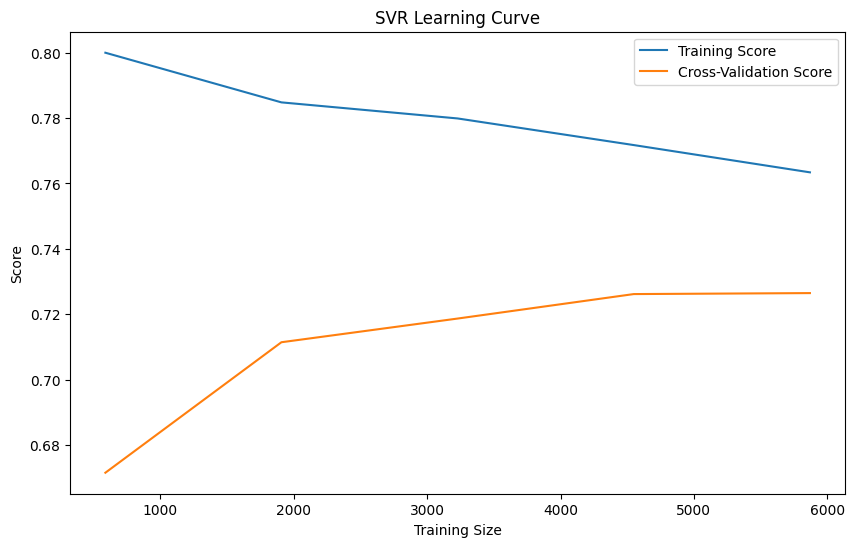

In [ ]:
#Show learning curve for best estimator
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(SVR(kernel='rbf',gamma='auto',
                                                            C = 8450, epsilon = 37), X=train_prepared, y=y_train, cv=3, scoring='r2')
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('SVR Learning Curve')
plt.legend()
plt.show()

SVR work best in terms of not overfitting the model.

## A full pipeline with both preparation and


In [ ]:
#put the model after the preparation pipeline
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("SVR", SVR(kernel='poly', C=10, epsilon=0.01))
    ])

#fitting the pipeline will fit the model
full_pipeline_with_predictor.fit(X_train, y_train)
#calling the predict method will transform the data and make predictions
full_pipeline_with_predictor.predict(X_test)

array([133.65327595, 136.07869722, 122.62936713, ..., 427.55932871,
       158.01984427,  58.43262223])

## Gradient Boosted Trees
- AdaBoost
- XGBoost
- Catboost

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:
# Initialize the base regressor
base_regressor = DecisionTreeRegressor(max_depth=5)

# Initialize AdaBoostRegressor
ada_regressor = AdaBoostRegressor(estimator=base_regressor, n_estimators=50, random_state=42)

# Train the model
ada_regressor.fit(train_prepared, y_train)


AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5), random_state=42)

In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(ada_regressor, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(ada_regressor, test_prepared, y_test)}")

RMSE on Train Set: 86.31339725945074
RMSE on Test Set: 94.4581979467916


Not Bad. Let's try Hyperparamter Tuning

In [ ]:
# Define the base estimator
base_regressor = DecisionTreeRegressor()

# Define the AdaBoost regressor
ada_regressor = AdaBoostRegressor(estimator=base_regressor)

# Define a grid of parameters over which to optimize the AdaBoost regressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'base_estimator__max_depth': [1, 2, 3, 4, 5]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=ada_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(train_prepared, y_train)


Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostRegressor is deprecated in favor of 'estimator'. See AdaBoostRegressor's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [1, 2, 3, 4, 5],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# Output the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", np.sqrt(-grid_search.best_score_))

# You can access the best estimator directly
best_model = grid_search.best_estimator_

# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(best_model, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(best_model, test_prepared, y_test)}")

Best parameters: {'base_estimator__max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 200}
Best cross-validation score: 77.10397116152532
RMSE on Train Set: 73.29831628489765
RMSE on Test Set: 81.01200559166851


### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
# Initialize XGBRegressor
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 1.5, n_estimators = 100)

# Train the model
xgb_regressor.fit(train_prepared, y_train)


XGBRegressor(alpha=1.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(xgb_regressor, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(xgb_regressor, test_prepared, y_test)}")

RMSE on Train Set: 59.43959798950069
RMSE on Test Set: 75.22150141102682


Looks Overfitted to me

In [ ]:
# Let's try gridsearchcv

# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'alpha': [1.5, 2, 2.5]
}

# Initialize the XGBRegressor
xgb_regressor = xgb.XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(train_prepared, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [1.5, 2, 2.5],
                         'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
# Output the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", np.sqrt(-grid_search.best_score_))

# You can access the best estimator directly
best_model = grid_search.best_estimator_

# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(best_model, train_prepared, y_train)}")

print(f"RMSE on Test Set: {model_rmse(best_model, test_prepared, y_test)}")

Best parameters: {'alpha': 2, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best cross-validation score: 69.50641287128546
RMSE on Train Set: 45.96217735617344
RMSE on Test Set: 74.85201050651223


### Catboost
- This package takes care of encoding categorical variables on its own
- Decision trees and gradient boosted trees normally are not sensitive to different scales of features. So I will skip the normalization too.

In [ ]:
%%capture

!pip install catboost

In [ ]:
from catboost import CatBoostRegressor, Pool

In [ ]:
def fill_nan_host_response_time(data):
  data['host_response_time'] = data['host_response_time'].fillna('No Data')

  return data


In [ ]:
# Building preprocessing pipeline fpr Catboost
num_pipeline1 = Pipeline([
      ('fill_nan', FunctionTransformer(fill_nan_in_money_cols))
    , ('knn_impute', FunctionTransformer(knn_impute_na_in_numerical_data))
    , ('winsorizing', FunctionTransformer(apply_winsorizing))
    #, ('Normalization', MinMaxScaler()) # comment out normalization if you dont need
])

cat_pipeline2 = Pipeline([
     ('fill_bools', FunctionTransformer(fill_missing_bools))
    , ('fill_host_response_time', FunctionTransformer(fill_nan_host_response_time)) #just for catboost, because it does not handles nan
    #, ('one_hot_encode', OneHotEncoder(sparse_output=False, drop='first'))
])

# Define your pipeline steps
full_pipeline1 = ColumnTransformer([
        ("num", num_pipeline1, num_attribs),
        ("cat", cat_pipeline2, cat_attribs),
    ])

In [ ]:
train_prepared1 = full_pipeline1.fit_transform(X_train)

In [ ]:
train_prepared1.shape, X_train.shape

((8805, 32), (8805, 32))

In [ ]:
test_prepared1 = full_pipeline1.transform(X_test)

In [ ]:
train_prepared1[0][20:]

array(['within an hour', 't', 't', 't', 't', 'Bungalow',
       'Entire home/apt', 'Real Bed', 't', 'strict_14_with_grace_period',
       'f', 'f'], dtype=object)

In [ ]:
train_prepared1[0]

array([100.0, 32.84692, -117.26819, 2.0, 1.0, 1.0, 1.0, 0.0, 75.0, 1.0,
       0.0, 134.0, 268.0, 99.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
       'within an hour', 't', 't', 't', 't', 'Bungalow',
       'Entire home/apt', 'Real Bed', 't', 'strict_14_with_grace_period',
       'f', 'f'], dtype=object)

In [ ]:
# In catboost, if we are feeding a numpy array, then we need to specify the indices of array that are categorical
# In our data Indices of categorical features start from 20
cat_features = list(range(20, 32))  # Columns 21 to 32 are categorical

# Create a Pool object with categorical feature indices
train_pool = Pool(train_prepared1, y_train, cat_features=cat_features)

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=10, depth=2, learning_rate=0.1, loss_function='RMSE', verbose=True)

# Train the model
model.fit(train_pool)

0:	learn: 133.7401961	total: 57.5ms	remaining: 517ms
1:	learn: 127.5369618	total: 63.2ms	remaining: 253ms
2:	learn: 122.0500449	total: 70.1ms	remaining: 164ms
3:	learn: 116.9019136	total: 75ms	remaining: 113ms
4:	learn: 112.4714515	total: 77.4ms	remaining: 77.4ms
5:	learn: 108.5488209	total: 80.7ms	remaining: 53.8ms
6:	learn: 105.0500195	total: 83.1ms	remaining: 35.6ms
7:	learn: 102.1748631	total: 86.5ms	remaining: 21.6ms
8:	learn: 99.4948163	total: 88.9ms	remaining: 9.87ms
9:	learn: 97.2766171	total: 91.1ms	remaining: 0us


In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(model, train_prepared1, y_train)}")

print(f"RMSE on Test Set: {model_rmse(model, test_prepared1, y_test)}")

RMSE on Train Set: 97.27661708102175
RMSE on Test Set: 104.8609110313323


In [ ]:
# Let's try GridSearchCV and Hyperparameter tuning
# Define the parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate' : [0.01, 0.05, 0.1],
    'iterations' : [30, 50, 100],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'thread_count': [4],
    'cat_features': [cat_features]  # specifying categorical features
}


# Initialize CatBoostRegressor
cb_regressor = CatBoostRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=cb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(train_prepared1, y_train, verbose=False)  # Set verbose to False to avoid long outputs


Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7b86de1d64d0>,
             n_jobs=-1,
             param_grid={'border_count': [32, 64, 128],
                         'cat_features': [[20, 21, 22, 23, 24, 25, 26, 27, 28,
                                           29, 30, 31]],
                         'depth': [4, 6, 8], 'iterations': [30, 50, 100],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'thread_count': [4]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
# Output the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", np.sqrt(-grid_search.best_score_))

# You can access the best estimator directly
best_model = grid_search.best_estimator_

# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {model_rmse(best_model, train_prepared1, y_train)}")

print(f"RMSE on Test Set: {model_rmse(best_model, test_prepared1, y_test)}")

Best parameters: {'border_count': 128, 'cat_features': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'depth': 8, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'thread_count': 4}
Best cross-validation score: 70.6632103009377
RMSE on Train Set: 60.9573131690283
RMSE on Test Set: 75.10002854107782


## NN

In [ ]:
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras

In [ ]:
train_prepared.shape, y_train.shape, test_prepared.shape, y_test.shape

((8805, 61), (8805,), (2202, 61), (2202,))

In [ ]:
train_prepared.shape[1]

61

In [ ]:
# Building a base NN model
# model = keras.models.Sequential([
#     keras.layers.Dense(24, activation="relu", input_shape=(train_prepared.shape[1],)),  # Adjusted for input features
#     keras.layers.Dense(12, activation="relu"),
#     keras.layers.Dense(6, activation="relu"),
#     keras.layers.Dense(1)  # Output layer for regression; 1 unit with no activation (linear)
# ])
model = keras.models.Sequential([
    keras.layers.Dense(16, activation="relu", input_shape=(train_prepared.shape[1],)),  # Increased the number of neurons
    # keras.layers.Dense(8, activation="relu"),  # Additional hidden layer
    # keras.layers.Dropout(0.2),  # Dropout layer for regularization
    keras.layers.Dense(4, activation="relu"),  # Another hidden layer
    keras.layers.Dense(1)  # Output layer for regression
])
# Compiling the model with mean squared error loss function for regression
# and a small learning rate for the SGD optimizer
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-2))


In [ ]:
1e-3

0.001

In [ ]:
# The model is now ready to be trained with X_train_scaled and y_train
model.fit(train_prepared, y_train, epochs=20, batch_size=128, validation_data=(test_prepared, y_test))

Epoch 1/20
69/69 [==============================] - 1s 5ms/step - loss: 5247666176.0000 - val_loss: 7139493.5000
Epoch 2/20
69/69 [==============================] - 0s 4ms/step - loss: 2457268.7500 - val_loss: 468505.4062
Epoch 3/20
69/69 [==============================] - 0s 4ms/step - loss: 170251.4375 - val_loss: 52114.2695
Epoch 4/20
69/69 [==============================] - 0s 4ms/step - loss: 29268.6504 - val_loss: 24860.3438
Epoch 5/20
69/69 [==============================] - 0s 4ms/step - loss: 20516.1133 - val_loss: 22870.7441
Epoch 6/20
69/69 [==============================] - 0s 4ms/step - loss: 19988.5918 - val_loss: 22662.3379
Epoch 7/20
69/69 [==============================] - 0s 4ms/step - loss: 19954.4707 - val_loss: 22626.2031
Epoch 8/20
69/69 [==============================] - 0s 4ms/step - loss: 19952.0059 - val_loss: 22616.6875
Epoch 9/20
69/69 [==============================] - 0s 4ms/step - loss: 19951.2637 - val_loss: 22618.8457
Epoch 10/20
69/69 [================

In [ ]:
np.sqrt(19948.9375)

141.24070765894655

In [ ]:
def nn_model_rmse(model, independent_data, target):
  # Step 1: Make predictions
  predictions = model.predict(independent_data)

  # Step 2: Compute MSE
  mse = np.mean((predictions.flatten() - target)**2)

  # Step 3: Compute RMSE
  return np.sqrt(mse)


In [ ]:
nn_model_rmse(model, test_prepared, y_test)

69/69 [==============================] - 0s 1ms/step


150.38750952565638

PCA

In [ ]:
# dimensionality reduction with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=14) # 14 features gets to mse=58
pca.fit(train_prepared)

print(pca.explained_variance_ratio_)

train_prepared = pca.transform(train_prepared)
test_prepared = pca.transform(test_prepared)

[0.13865719 0.10747254 0.09322331 0.07975372 0.07083769 0.05446187
 0.04895483 0.0403877  0.03704884 0.03125197 0.02864035 0.02791969
 0.02432937 0.02080461]


In [ ]:
train_prepared.shape, y_train.shape, test_prepared.shape, y_test.shape

((8805, 14), (8805,), (2202, 14), (2202,))

In [ ]:
# trying PCA data on NN

# Building a base NN model

model = keras.models.Sequential([
    keras.layers.Dense(8, activation="relu", input_shape=(train_prepared.shape[1],)),  # Increased the number of neurons
    # keras.layers.Dense(8, activation="relu"),  # Additional hidden layer
    # keras.layers.Dropout(0.2),  # Dropout layer for regularization
    keras.layers.Dense(4, activation="relu"),  # Another hidden layer
    keras.layers.Dense(1)  # Output layer for regression
])


# Compiling the model with mean squared error loss function for regression
# and a small learning rate for the SGD optimizer
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))


In [ ]:
# The model is now ready to be trained with X_train_scaled and y_train
model.fit(train_prepared, y_train, epochs=50, batch_size=128, validation_data=(test_prepared, y_test))

Epoch 1/50
69/69 [==============================] - 1s 9ms/step - loss: 48105.1836 - val_loss: 50190.4922
Epoch 2/50
69/69 [==============================] - 0s 4ms/step - loss: 42040.5547 - val_loss: 43804.3477
Epoch 3/50
69/69 [==============================] - 0s 5ms/step - loss: 36710.3438 - val_loss: 38916.7188
Epoch 4/50
69/69 [==============================] - 0s 5ms/step - loss: 32663.5547 - val_loss: 35183.4766
Epoch 5/50
69/69 [==============================] - 0s 5ms/step - loss: 29594.7676 - val_loss: 32324.0840
Epoch 6/50
69/69 [==============================] - 0s 5ms/step - loss: 27266.3926 - val_loss: 30133.1562
Epoch 7/50
69/69 [==============================] - 0s 6ms/step - loss: 25500.3789 - val_loss: 28448.5781
Epoch 8/50
69/69 [==============================] - 0s 4ms/step - loss: 24157.9395 - val_loss: 27152.0254
Epoch 9/50
69/69 [==============================] - 0s 4ms/step - loss: 23139.0586 - val_loss: 26154.3359
Epoch 10/50
69/69 [===========================

In [ ]:
# Let's calcualte rmse on both train and test sets

print(f"RMSE on Train Set: {nn_model_rmse(model, train_prepared, y_train)}")

print(f"RMSE on Test Set: {nn_model_rmse(model, test_prepared, y_test)}")

276/276 [==============================] - 0s 2ms/step
RMSE on Train Set: 95.73844376577031
69/69 [==============================] - 0s 2ms/step
RMSE on Test Set: 105.35052869587552


276/276 [==============================] - 0s 2ms/step
RMSE on Train Set: 95.73844376577031

69/69 [==============================] - 0s 2ms/step
RMSE on Test Set: 105.35052869587552

## Data Preprocessing Without Winsorizing or Normalization for low outlier sensitive algorithms such as Decision Trees, Gradient Boosted Trees

In [ ]:
# Building preprocessing pipeline fpr Catboost
num_pipeline3 = Pipeline([
      ('fill_nan', FunctionTransformer(fill_nan_in_money_cols))
    , ('knn_impute', FunctionTransformer(knn_impute_na_in_numerical_data))
    # , ('winsorizing', FunctionTransformer(apply_winsorizing))
    #, ('Normalization', MinMaxScaler()) # comment out normalization if you dont need
])

cat_pipeline3 = Pipeline([
     ('fill_bools', FunctionTransformer(fill_missing_bools))
    , ('one_hot_encode', OneHotEncoder(sparse_output=False, drop='first'))
])

# Define your pipeline steps
full_pipeline3 = ColumnTransformer([
        ("num", num_pipeline3, num_attribs),
        ("cat", cat_pipeline3, cat_attribs),
    ])

In [ ]:
train_prepared3 = full_pipeline3.fit_transform(X_train)
y_train = train_set['nightly_price'].copy()

In [ ]:
test_prepared3 = full_pipeline3.transform(X_test)
y_test = test_set['nightly_price'].copy()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
# Will try Decison Trees, RF, Adaboost, XGBoost on their best params above

tree_reg = DecisionTreeRegressor(random_state=42)

#use RandomForestRegressor to fit the data
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42,
                                   max_features=0.5,
                                   min_impurity_decrease=0.1,
                                   min_samples_leaf=2,
                                   min_samples_split=4)

# Define the base estimator

base_regressor = DecisionTreeRegressor(max_depth=5)

# Define the AdaBoost regressor
ada_reg= AdaBoostRegressor(estimator=base_regressor,
                                  n_estimators=200,
                                  learning_rate=0.01,
                                  )

# Initialize XGBRegressor
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 7, alpha = 2, n_estimators = 100)



In [ ]:
#Let's fit all these models
# Storing models in a dictionary
models_dict = {
    'tree_reg': tree_reg,
    'forest_reg': forest_reg,
    'ada_reg': ada_reg,
    'xgb_reg': xgb_reg
}


# Iterating over models
for name, model in models_dict.items():
    print(name)
    model.fit(train_prepared3, y_train)
    print(f"RMSE on Train Set: {model_rmse(model, train_prepared3, y_train)}")
    print(f"RMSE on Test Set: {model_rmse(model, test_prepared3, y_test)}")
    print("\n")


tree_reg
RMSE on Train Set: 0.0
RMSE on Test Set: 174.96997406873294


forest_reg
RMSE on Train Set: 61.76772763062866
RMSE on Test Set: 126.82656404182701


ada_reg
RMSE on Train Set: 115.03759763544514
RMSE on Test Set: 134.23893476849517


xgb_reg
RMSE on Train Set: 64.85500743245619
RMSE on Test Set: 131.63508507588932




The above results dont look promising. Last Hope: Feature Transformation and Reduction. A few ideas
1. Drop all those review scores cols and just keep review ratings col or take an avg of the review_score cols. That would reduce review features from 5-6 to 1-2.
2. bed_type col has 5 types: Real Bed, Futon, Couch, Pull-out Sofa and Airbed. The last 4 types together only have 90 rows in data as compared to 10K rows of Real Bed. Idea is to label last 4 bed types together as "Not Real Bed". (Also last 4 type's price distribution (min, max, mean, median) is similar) This would reduce one hot encoded bed_type features from 4 to 1.
3. In property_type col, there are some types that appear less than 5 times and some only appear once, so property_types that appear less than 5 times are labeled as "Other". Resulting in reduction of 4-5 one-hot encoded property features.

##Thoughts??

## Summary

In [ ]:
import pandas as pd

# Create a dictionary with the model names and their corresponding RMSE values
data = {
    'Model': ['NN PCA', 'CatBoost', 'XGBoost', 'AdaBoost', 'SVR', 'RF', 'Ridge'],
    'Train_RMSE': [95.73844376577031, 97.27661708102175, 45.96217735617344, 73.29831628489765, 75.39414644169473, 33.283517567344916, 78.07540845752695],
    'Test_RMSE': [105.35052869587552, 104.8609110313323, 74.85201050651223, 81.01200559166851, 80.9589040711945, 74.43852040697696, 82.87010966639706]
}

# Create DataFrame
df_new = pd.DataFrame(data)

df_new


,Model,Train_RMSE,Test_RMSE
0,NN PCA,95.738444,105.350529
1,CatBoost,97.276617,104.860911
2,XGBoost,45.962177,74.852011
3,AdaBoost,73.298316,81.012006
4,SVR,75.394146,80.958904
5,RF,33.283518,74.438520
6,Ridge,78.075408,82.870110
